<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ViT_FullFinetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = Flowers102(root='./data', split='test', transform=transform, download=True)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=102, ignore_mismatched_sizes=True)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([102, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience} at epoch {epoch}')
            if self.counter >= self.patience:
                self.early_stop = True
                print(f'Early stopping at epoch {epoch}. No improvement in validation accuracy for {self.patience} consecutive epochs.')
        else:
            self.best_score = score
            self.counter = 0


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, model_save_path, epochs=5, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_val_accuracy = 0.0
    best_model_wts = None


    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total


        val_loss, val_accuracy = validate_model(model, val_loader, criterion)


        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)


        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")


        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()


        early_stopping(val_accuracy, epoch + 1)

        if early_stopping.early_stop:

            break


    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), model_save_path)



    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = total_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [ ]:
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=25,model_save_path='Best_ViT_FullFineTuned.pth')

Epoch [1/25], Train Loss: 4.4381, Train Accuracy: 0.0667, Validation Loss: 3.9834, Validation Accuracy: 0.2010
Epoch [2/25], Train Loss: 3.3977, Train Accuracy: 0.5637, Validation Loss: 3.2113, Validation Accuracy: 0.6755
Epoch [3/25], Train Loss: 2.3912, Train Accuracy: 0.9422, Validation Loss: 2.4866, Validation Accuracy: 0.8686
Epoch [4/25], Train Loss: 1.5094, Train Accuracy: 0.9961, Validation Loss: 1.9195, Validation Accuracy: 0.9137
Epoch [5/25], Train Loss: 0.8957, Train Accuracy: 1.0000, Validation Loss: 1.5448, Validation Accuracy: 0.9353
Epoch [6/25], Train Loss: 0.5354, Train Accuracy: 1.0000, Validation Loss: 1.3014, Validation Accuracy: 0.9451
Epoch [7/25], Train Loss: 0.3370, Train Accuracy: 1.0000, Validation Loss: 1.1457, Validation Accuracy: 0.9520
Epoch [8/25], Train Loss: 0.2293, Train Accuracy: 1.0000, Validation Loss: 1.0400, Validation Accuracy: 0.9529
Epoch [9/25], Train Loss: 0.1667, Train Accuracy: 1.0000, Validation Loss: 0.9639, Validation Accuracy: 0.9559
E

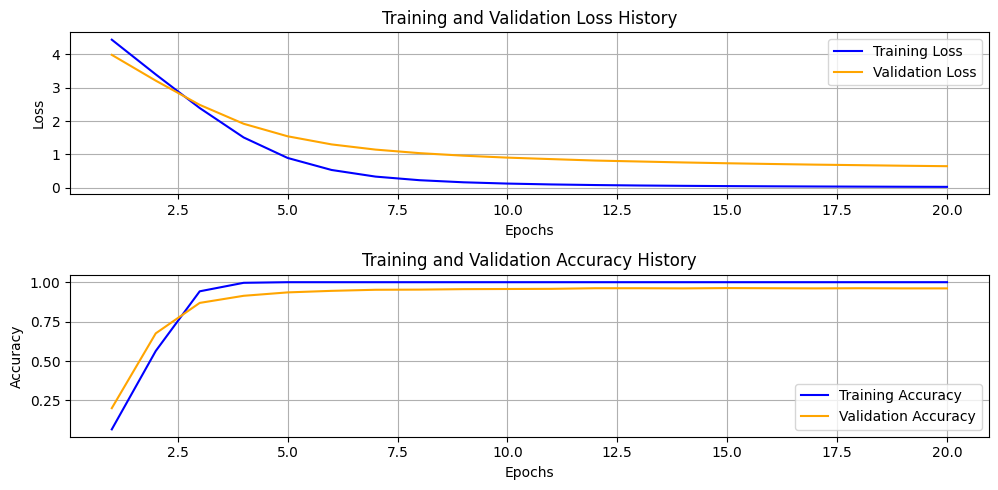

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, test_loader)

Test Accuracy: 94.29%
